<h4 style="text-align: center;">NOTEBOOK</h4>
<p style="text-align: center; font-style: italic">~~ FETCH AND PREPARE DATA ~~</p>
</br>

<p style="text-align: justify; margin-left: 80px; margin-right: 80px;">
Ce notebook a pour objectif de récupérer les données présentes sur le serveur selon les besoins de l'entraînement du/des modèles d'IA pour la détection des glyphes cunéiformes.</p>

</br>

<h3 style="text-align: justify; margin-left: 40px; margin-right: 80px;">
<b>Sommaire</b>
</h3>

<span style="margin-left: 80px;">- 1 - Récupérer les données et les images</span></br>
<span style="margin-left: 80px;">- 2 - Décoder les images et les découper selon les vues</span></br>
<span style="margin-left: 80px;">- 3 - Décoder les images et les découper selon les glyphes (Train / Test)</span></br>
<span style="margin-left: 80px;">- 4 - Décoder les images et les découper selon les glyphes (Global Folder)</span></br>

</br>

---
</br>

In [49]:
import base64
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import sys

from ast import literal_eval
from io import BytesIO
from PIL import Image
from tqdm import tqdm

# - Import Personal Library
sys.path.append("utils/")    ## - db_data_fetch
import db_data_fetch as dbdf

## Get data from database (annotation bbox and images)

#### Fetch Data Bbox Annotation and Save

In [29]:
SPLIT_SET = ['train', 'test']

df_train = pd.DataFrame()
df_test = pd.DataFrame()

train_images = pd.DataFrame()
test_images = pd.DataFrame()

In [30]:
for param in SPLIT_SET:
    result = dbdf.fetch_data_bbox_annotation(param)

    if param == 'train':
        df_train = result
    elif param == 'test':
        df_test = result

Extraction is OK ; PostgreSQL connection is closed
Extraction is OK ; PostgreSQL connection is closed


In [33]:
directory = 'data/'

if not os.path.exists(directory):
    os.makedirs(directory)

df_train.to_csv('data/train.csv', index=False)
df_test.to_csv('data/test.csv', index=False)

#### Fetch Image (without save)

In [34]:
for param in SPLIT_SET:
    result = dbdf.fetch_image(param)

    if param == 'train':
        train_images = result
    elif param == 'test':
        test_images = result

Extraction is OK ; PostgreSQL connection is closed
Extraction is OK ; PostgreSQL connection is closed


## Crop by view

In [35]:
def crop_img(img: Image.Image, bbox: np.ndarray) -> Image.Image:
    """Crop image reference to specific dimensions 
    with bbox (x_min, y_min, x_max, y_max) in numpy array format"""
    return img.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

##### └── Train

In [36]:
directory = 'data/train_tablets_image/'

## - Convert the bbox_segment to a numpy array for the crop_img function
train_images['bbox_segment'] = train_images['bbox_segment']\
                               .apply(literal_eval).apply(np.array)

for index, row in tqdm(train_images.iterrows(), total=train_images.shape[0]):
    picture_data = row['tablet_picture']
    binary_data = base64.b64decode(picture_data)

    image = Image.open(BytesIO(binary_data))
    tablet_view = crop_img(image, row['bbox_segment'])

    if not os.path.exists(directory):
        os.makedirs(directory)

    tablet_view.save(os.path.join(directory, f'{row["tablet_name"]}.jpg'))

    # tablet_view.show()

100%|██████████| 66/66 [00:07<00:00,  8.68it/s]


##### └── Test

In [37]:
directory = 'data/test_tablets_image/'

## - Convert the bbox_segment to a numpy array for the crop_img function
test_images['bbox_segment'] = test_images['bbox_segment']\
                               .apply(literal_eval).apply(np.array)

for index, row in tqdm(test_images.iterrows(), total=test_images.shape[0]):
    picture_data = row['tablet_picture']
    binary_data = base64.b64decode(picture_data)

    image = Image.open(BytesIO(binary_data))
    tablet_view = crop_img(image, row['bbox_segment'])

    if not os.path.exists(directory):
        os.makedirs(directory)

    tablet_view.save(os.path.join(directory, f'{row["tablet_name"]}.jpg'))

    # tablet_view.show()

  0%|          | 0/56 [00:00<?, ?it/s]

100%|██████████| 56/56 [00:04<00:00, 11.66it/s]


##### └── Check result crop with csv information

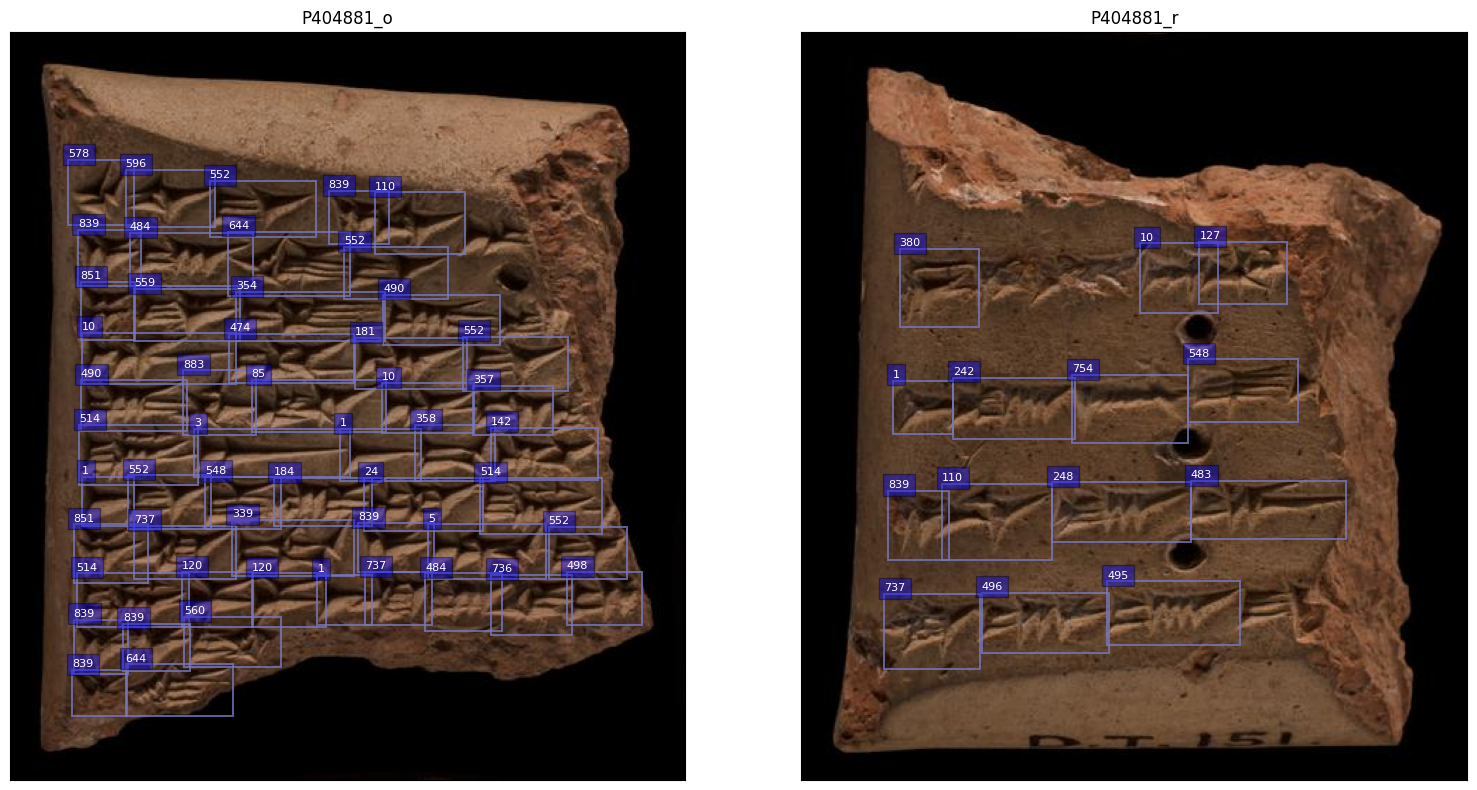

In [38]:
df_train = pd.read_csv('data/train.csv')
df_train = df_train[df_train['tablet_name'].isin(['P404881_o', 'P404881_r'])]

df_train['bbox_glyph'] = df_train['bbox_glyph']\
    .apply(literal_eval).apply(np.array)

path_tablet_o = "data/train_tablets_image/P404881_o.jpg"
path_tablet_r = "data/train_tablets_image/P404881_r.jpg"


def plot_boxes(boxes: np.ndarray, labels: np.ndarray, ax: plt.Axes) -> None:
    for idx, bbox in enumerate(boxes):
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]), 
                           bbox[2] - bbox[0], 
                           bbox[3] - bbox[1],
                          fill=False, 
                          edgecolor='#7878bf', 
                          alpha=0.8, 
                          linewidth=1.4))

        ax.text(bbox[0], bbox[1] - 2, f"{labels[idx]}",
                bbox=dict(facecolor='blue', alpha=0.4), 
                fontsize=8, color='white')


fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for idx, occurrence in enumerate(['P404881_o', 'P404881_r']):
    path_tablet = path_tablet_o if occurrence == 'P404881_o' else path_tablet_r
    pil_im = Image.open(path_tablet)

    selected_data = df_train[df_train['tablet_name'] == occurrence]

    for s_idx, s_rec in selected_data.iterrows():
        ax[idx].imshow(np.asarray(pil_im))
        ax[idx].set_title(f"{s_rec['tablet_name']}")
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])

        sign_bboxes = [s_rec['bbox_glyph']]
        sign_lbls = [s_rec['mzl_label']]

        plot_boxes(sign_bboxes, sign_lbls, ax=ax[idx])

plt.tight_layout()
plt.show()

## Crop by glyphs _classified by mzl in folder also_ (Global One Folder)

Récupération des données selon la stratégie d'entraînement:

- Au-dessus de 100 occurences :  
[1, 10, 24, 89, 110, 112, 248, 252, 380, 490, 514, 552, 566, 596, 661, 724, 736, 748, 754, 839, 859, 869]  

- Entre 50 et 200 occurences :  
[14, 71, 92, 98, 111, 113, 118, 142, 164, 260, 266, 358, 464, 495, 498, 561, 567, 578, 580, 589, 599, 737, 753, 808, 812, 851]  

- Entre 25 et 50 occurences:  
[16, 85, 86, 90, 120, 127, 136, 151, 172, 181, 255, 258, 350, 469, 491, 496, 501, 511, 548, 553, 560, 631, 641, 646, 708, 711, 828, 856]

In [39]:
def crop_img(img: Image.Image, bbox: np.ndarray) -> Image.Image:
    """Crop image reference to specific dimensions 
    with bbox (x_min, y_min, x_max, y_max) in numpy array format"""
    return img.crop((bbox[0], bbox[1], bbox[2], bbox[3]))


def save_glyphs(save_directory: str, row_tablet: pd.Series,
                glyph_view: Image.Image) -> None:
    mzl_directory = os.path.join(save_directory, str(row_tablet['mzl_label']))
    if not os.path.exists(mzl_directory):
        os.makedirs(mzl_directory)

    num_files = len([name for name in os.listdir(mzl_directory) 
                     if os.path.isfile(os.path.join(mzl_directory, name))])
    glyph_filename = f"{row_tablet['mzl_label']}_{num_files + 1}.jpg"
    glyph_view.save(os.path.join(mzl_directory, glyph_filename))

In [40]:
list_over100 = [1, 10, 24, 89, 110, 112, 248, 252, 380, 490, 514, 552, 566, 596, 661, 724, 736, 748, 754, 839, 859, 869]
list_50_to_100 = [14, 71, 92, 98, 111, 113, 118, 142, 164, 260, 266, 358, 464, 495, 498, 561, 567, 578, 580, 589, 599, 737, 753, 808, 812, 851]
list_25_to_50 = [16, 85, 86, 90, 120, 127, 136, 151, 172, 181, 255, 258, 350, 469, 491, 496, 501, 511, 548, 553, 560, 631, 641, 646, 708, 711, 828, 856]

##### └── Train

In [41]:
## - Saving Folders
save_directory_over100 = 'data/glyphs_image/over_100/'
save_directory_50_to_100 = 'data/glyphs_image/50_to_100/'
save_directory_25_to_50 = 'data/glyphs_image/25_to_50/'

## - Data Directory
train_annotations = pd.read_csv('data/train.csv')
train_image_directory = 'data/train_tablets_image/'

train_annotations['bbox_glyph'] = train_annotations['bbox_glyph']\
                                  .apply(literal_eval).apply(np.array)

unique_tablets = {}
for index, row_tablet in tqdm(train_annotations.iterrows(), 
                              total=train_annotations.shape[0]):
    tablet_name = row_tablet['tablet_name']
    if tablet_name not in unique_tablets:
        unique_tablets[tablet_name] = Image.open(
            os.path.join(train_image_directory, tablet_name + '.jpg'))

    tablet_img = unique_tablets[tablet_name]
    glyph_view = crop_img(tablet_img, row_tablet['bbox_glyph'])

    if row_tablet['mzl_label'] in list_over100:
        mzl_directory = save_directory_over100
        save_glyphs(save_directory_over100, row_tablet, glyph_view)
    elif row_tablet['mzl_label'] in list_50_to_100:
        mzl_directory = save_directory_50_to_100
        save_glyphs(save_directory_50_to_100, row_tablet, glyph_view)
    elif row_tablet['mzl_label'] in list_25_to_50:
        mzl_directory = save_directory_25_to_50
        save_glyphs(save_directory_25_to_50, row_tablet, glyph_view)
    else:
        continue

  0%|          | 0/4422 [00:00<?, ?it/s]

100%|██████████| 4422/4422 [00:06<00:00, 635.69it/s]


##### └── Test

In [42]:
## - Saving Folders
save_directory_over100 = 'data/glyphs_image/over_100/'
save_directory_50_to_100 = 'data/glyphs_image/50_to_100/'
save_directory_25_to_50 = 'data/glyphs_image/25_to_50/'

## - Data Directory
test_annotations = pd.read_csv('data/test.csv')
test_image_directory = 'data/test_tablets_image/'

test_annotations['bbox_glyph'] = test_annotations['bbox_glyph']\
                                  .apply(literal_eval).apply(np.array)

unique_tablets = {}
for index, row_tablet in tqdm(test_annotations.iterrows(), 
                              total=test_annotations.shape[0]):
    tablet_name = row_tablet['tablet_name']
    if tablet_name not in unique_tablets:
        unique_tablets[tablet_name] = Image.open(
            os.path.join(test_image_directory, tablet_name + '.jpg'))

    tablet_img = unique_tablets[tablet_name]
    glyph_view = crop_img(tablet_img, row_tablet['bbox_glyph'])


    if row_tablet['mzl_label'] in list_over100:
        mzl_directory = save_directory_over100
        save_glyphs(save_directory_over100, row_tablet, glyph_view)
    elif row_tablet['mzl_label'] in list_50_to_100:
        mzl_directory = save_directory_50_to_100
        save_glyphs(save_directory_50_to_100, row_tablet, glyph_view)
    elif row_tablet['mzl_label'] in list_25_to_50:
        mzl_directory = save_directory_25_to_50
        save_glyphs(save_directory_25_to_50, row_tablet, glyph_view)
    else:
        continue

100%|██████████| 3454/3454 [00:06<00:00, 510.22it/s]


##### └── Check result glyphs crop

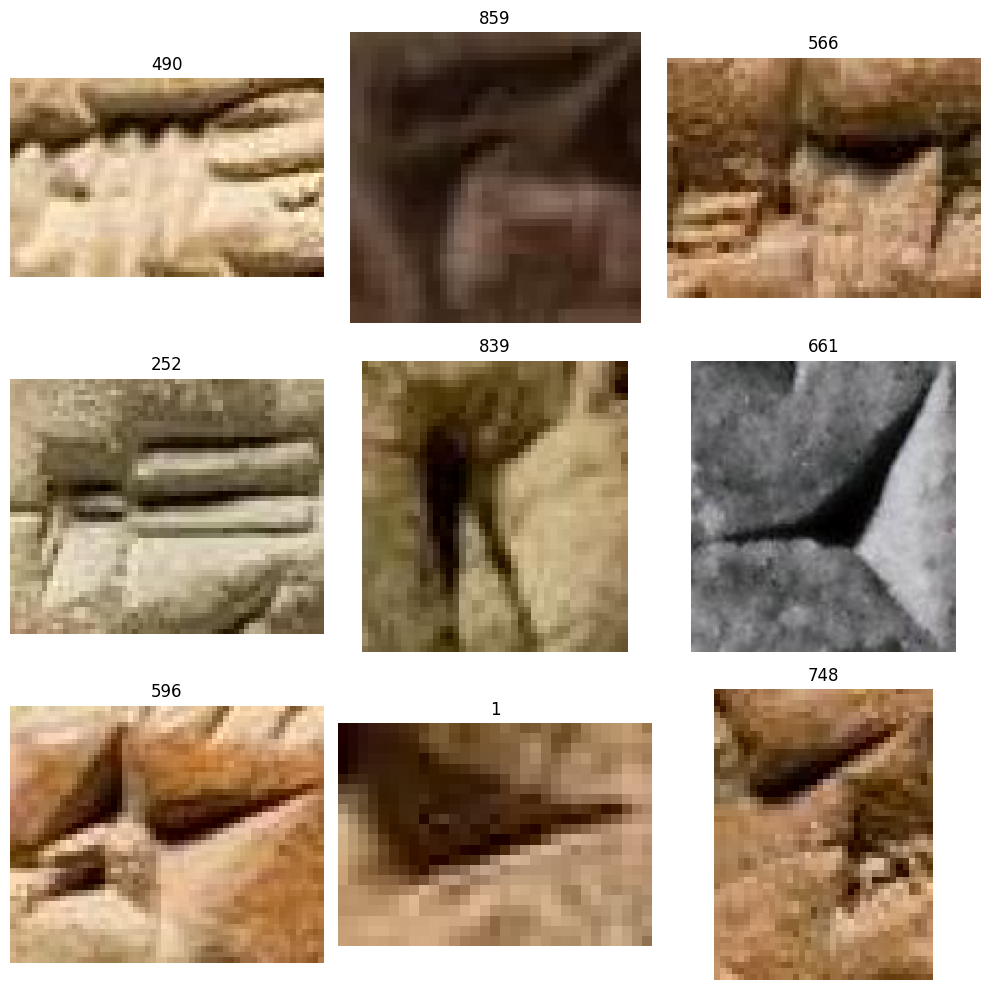

In [50]:
directory = 'data/glyphs_image/over_100/'
subfolders = [subfolder for subfolder in os.listdir(directory) 
              if os.path.isdir(os.path.join(directory, subfolder))]

selected_subfolders = random.sample(subfolders, 9)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, subfolder in enumerate(selected_subfolders):

    image_files = [file for file in os.listdir(os.path.join(directory, 
                    subfolder)) if file.endswith('.jpg')]

    image_file = random.choice(image_files)

    image_path = os.path.join(directory, subfolder, image_file)
    image = Image.open(image_path)

    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(subfolder)
    ax.axis('off')

plt.tight_layout()
plt.show()


----
#
<h2 style="text-align: center;">END - FETCH - PREPARATION DATA</h2>